# Set Up

In [2]:
%pwd

'/pscratch/sd/m/mansisak/memorization/figs'

In [3]:
!module load conda

In [4]:
!conda activate /pscratch/sd/m/mansisak/memorization/env/

In [5]:
ls 

csv/
inc_backdoor_grid_scatter.pdf
inc_backdoor_scatter.pdf
inc_noise_grid_scatter.pdf
inc_noise_scatter.pdf
lang_backdoor_grid_scatter.pdf
lang_backdoor_scatter.pdf
lang_bd_boxen_plots.pdf
lang_noise_boxen_plots.pdf
lang_noise_grid_scatter.pdf
lang_noise_scatter.pdf
lm_bd_reg.pdf
lm_bd_test_perplexity.pdf
lm_bd_train_loss.pdf
lm_bd_train.pdf
lm_dup_noise_train.pdf
lm_noise_reg.pdf
math_backdoor_grid_scatter.pdf
math_backdoor_scatter.pdf
math_bd_boxen_plots.pdf
math_bd_reg.pdf
math_bd_test_acc.pdf
math_bd_train_loss.pdf
math_bd_train.pdf
math_noise_boxen_plots.pdf
math_noise_grid_scatter.pdf
math_noise_reg.pdf
math_noise_scatter.pdf
math_noise_test_acc.pdf
math_noise_train_loss.pdf
math_noise_train.pdf
mult_backdoor_grid_scatter.pdf
mult_backdoor_scatter.pdf
mult_noise_grid_scatter.pdf
mult_noise_scatter.pdf
pythia_compare_localization_over_time_plot.pdf
pythia_grid_scatter.pdf
pythia_localization_hp_scatter_plot.pdf
pythia_method_scatter_kde_plot.pdf
pythia_scatter.pdf
pythia_unlearni

In [6]:
import pandas as pd
import numpy as np
import torch
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Check if experiments finished

In [7]:
def check_if_hp_run_fin(csv, model_name):
    total_exp = 0
    total_finished = 0

    df = pd.read_csv(csv)
    mask = df.localization_method == "base_stats"

    for loc_method in [
      "act",
      "hc",
      "slim",
      "durable",
      "durable_agg",
      "random",
      "random_greedy",
      "greedy",
  ]:
        for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8]:
            if loc_method not in ["random", "random_greedy"]:
                if ratio >= 0.1:
                    continue

          # this ratio is too small for neuron-level methods
            if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                if ratio <= 0.0001:
                    continue

            if loc_method in ["greedy"]:
                if ratio > 0.00001:
                    continue

            if loc_method in ["slim", "hc", "random"]:
                for epochs in [1, 10, 20]:
                    total_exp += 1
                    if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['model_name'] == model_name)).any():
                      #print("finsihed")
                      total_finished += 1
                        
            if loc_method in ["random_greedy"]:
                for epochs in [1, 10, 20]:
                    for loss_weighting in [0.9, 0.7, 0.5]:
                        total_exp += 1
                        if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['loss_weighting'] == loss_weighting)& (df['model_name'] == model_name)).any():
                          #print("finsihed")
                          total_finished += 1
                        #else:
                        #    print(f'{loc_method} {ratio} {epochs} {loss_weighting}')
                            
                        

                #here we check ratio, loc_method, epoch
            if loc_method in ["zero", "act", 'durable', 'durable_agg', 'greedy',]:
                total_exp += 1
                if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method)& (df['model_name'] == model_name)).any():
                    #print("finsihed")
                    total_finished += 1
                else:
                    print(f'{loc_method} {ratio} {epochs} {loss_weighting}')
            #here we check ratio, loc_method

  #print("total experiments: ", total_exp)
    print(f"total finished: {total_finished}/{total_exp}")
    if total_exp == total_finished:
        return 1
    return 

In [8]:
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"
        csv = (f'{result_path}{file_name}')
        print(csv)

        check_if_hp_run_fin(csv, model_name)

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/localization_results_36000.csv
total finished: 152/152
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/72000/EleutherAI_edit/localization_results_72000.csv
total finished: 152/152
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/108000/EleutherAI_edit/localization_results_108000.csv
total finished: 152/152
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/localization_results_143000.csv
total finished: 152/152
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/localization_results_36000.csv
total finished: 152/152
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
/pscratch/

In [9]:
# some of the mem_seqs didn't save we need to recompute them:

def print_edited_model_paths(parent_path):
    list_of_models = []
    dfs = []

    total_exp = 0
    for model_name in ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]:
            
        y_idx = 0
        for loc_method in [
            "act",
            "hc",
            "slim",
            "durable",
            "durable_agg",
            "random",
            "random_greedy",
            "greedy",
        ]: 
            for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8]:
                for epochs in [1, 10, 20]:
                    for loss_weight in [0.9, 0.7, 0.5,]:
                        
                        if epochs > 1:
                            if loc_method not in ["slim", "hc","random", "random_greedy"]:
                                continue
                        if loss_weight > 0.9:
                            if loc_method not in ["random_greedy"]:
                                continue
                        if loc_method not in ["random", "random_greedy"]:
                            if ratio >= 0.1:
                                continue

                        
                        seq_before = []
                        seq_after = []
                        steps = [36000, 72000, 108000, 143000]
                        for step in steps:
                            
                            file_name = f"localization_results_{step}.csv"
                            csv_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"
                            csv = (f'{csv_path}{file_name}')
                            df = pd.read_csv(csv)
                            
                            result_path = (
                                f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                            )


                            # this ratio is too small for neuron-level methods
                            if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                                if ratio <= 0.0001:
                                    continue

                            if loc_method in ["greedy"]:
                                if ratio > 0.00001:
                                    continue

                            ######
                            if loc_method in ["greedy", "durable", "durable_agg", "act"]:
                                model_path = f"{result_path}/{model_name}"
                                mem_seq_path = f"{result_path}/mem_seq_{model_name}"
                                total_exp += 1
                                idx = df.index[(df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['model_name'] == f"EleutherAI/{model_name}")].tolist()
                                #print(idx)

                            if loc_method in ["slim", "hc"]:
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/1000/0.1/0.1/{model_name}"
                                    )
                                    mem_seq_path = model_path = (
                                        f"{result_path}/{epochs}/1000/0.1/0.1/mem_seq_{model_name}"
                                    )
                                    idx = df.index[(df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['model_name'] == f"EleutherAI/{model_name}")].tolist()
                                    #print(idx)
                            if loc_method in ["random"]:
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}"
                                    )
                                    mem_seq_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/mem_seq_{model_name}"
                                    )
                                    idx = df.index[(df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['model_name'] == f"EleutherAI/{model_name}")].tolist()

                            if loc_method in ["random_greedy"]:
                                    #print("random_greedy")
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{loss_weight}/{model_name}"
                                    )
                                    mem_seq_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{loss_weight}/mem_seq_{model_name}"
                                    )
                                    idx = df.index[(df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['loss_weighting'] == loss_weight)& (df['model_name'] == f"EleutherAI/{model_name}")].tolist()
                                    #print(idx)

                            if os.path.isfile(model_path):
                                #if loc_method == "random_greedy": 
                                #    print("edited model exists:", model_path)
                                #    print(mem_seq_path)
                                list_of_models.append(model_path)


                                #load original mem set
                                if "2" in model_name:
                                    mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
                                if "6" in model_name:
                                    mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
                                seq_before.append(mem_seq_original)
                                #print(len(seq_before))

                                #load mem set after unlearning
                                mem_seq_after_edit = torch.load(mem_seq_path,map_location=torch.device('cpu'))
                                seq_after.append(mem_seq_after_edit)

                            else:
                            #    #print("edited model doesn't exist yet: ", model_path) 
                                if len(idx) == 1:
                                    print("IDX of non-existent path: ", idx)
                            #        df.loc[idx,'localization_method'] = df.loc[idx,'localization_method'] + "_old"
                            #        df.to_csv(csv)
                                
                        #if len(seq_before) == len(steps):
                        #    common_seqs = get_common_mem_seq_at_all_time(seq_before)
                        #    df = check_overlap(seq_after, common_seqs)
                        #    df.loc[:,"loc_method"] = loc_method
                        #    dfs.append(df)


    print("total_expeirments: ", total_exp)
    return list_of_models #, pd.concat(dfs)

parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"

list_of_models =  print_edited_model_paths(parent_path)

total_expeirments:  2208


# Filter Unwanted Experiments

In [49]:
def grab_valid_experiments(df):
  mask = (df.localization_method.isin(["hc","random_greedy","random","slim","ig"]) & (df.batch_size == 512))
  df = df[~mask]
  print(df.shape)

  total_exp = 0
  total_finished = 0
  df.loc[:, ['experiment']] = 0


  #df = pd.read_csv(csv)
  mask = df.localization_method == "base_stats"
  base_stat_idx = df_model.index[df_model['unlearn_set_name'].isna()][0]
  #print("base stats", base_stat_idx)

  df.loc[base_stat_idx, ['experiment']] = 1

  #NOTE(MS): this will only work for no dup categories (for lang will need to make it more fancy)
  #here we check if there is any mem at all -- if not, then we continue

  for loc_method in [
      #"zero",
      "act",
      "hc",
      "slim",
      "durable",
      "durable_agg",
      "random",
      "random_greedy",
      "greedy",
      #"ig",
      #"obs",
  ]:
    for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8]:

      if loc_method not in ["random", "random_greedy"]:
              if ratio >= 0.1:
                  continue

      # this ratio is too small for neuron-level methods
      if loc_method in ["zero", "hc", "ig", "slim", "act"]:
          if ratio <= 0.0001:
              continue

      if loc_method in ["greedy"]:
          if ratio > 0.00001:
              continue

      if loc_method in ["slim", "hc", "random"]:
          for epochs in [1, 10, 20]:
            total_exp += 1
            if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs)).any():
              index = df.index[((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) )].tolist()[0]
              df.loc[index, ['experiment']] = 1
              total_finished += 1
            else:
              print(loc_method)
      if loc_method in ["random_greedy"]:
          for epochs in [1, 10, 20]:
            for loss_weight in [0.9, 0.7, 0.5]:
              total_exp += 1
              if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['loss_weighting'] == loss_weight)).any():
                index = df.index[((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs) & (df['loss_weighting'] == loss_weight))].tolist()[0]
                df.loc[index, ['experiment']] = 1
                total_finished += 1
              else:
                print(loc_method)
            #here we check ratio, loc_method, epoch

      if loc_method in ["zero", "act", 'durable', 'durable_agg', 'obs', 'greedy', 'ig']:
        total_exp += 1
        if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method)).any():
              index = df.index[((df['ratio'] == ratio) & (df['localization_method'] == loc_method))].tolist()[0]
              df.loc[index, ['experiment']] = 1
              total_finished += 1
        else:
          print(loc_method, ratio)
        #here we check ratio, loc_method

  #print("total experiments: ", total_exp)
  print(f"total finished: {total_finished}/{total_exp}")
  #filtered_df = df.drop(df[df.experiment != 1].index)
  filtered_df = df[df.experiment == 1]

  print(filtered_df.shape)
  return filtered_df

#csv = "/eagle/projects/argonne_tpc/mansisak/memorization/model_ckpts/noise/dup/wiki_fast/20_150_3_128_0.001/four_layer_edit/localization_results_100.csv"
#csv = "/eagle/projects/argonne_tpc/mansisak/memorization/model_ckpts/noise/not_dup/mult/20000_3000_20_150_1_128_0.001/four_layer_edit/localization_results_3500.csv"
#df = pd.read_csv(csv)
#check_if_hp_run_fin(csv)

#print(df.columns)
#df = grab_valid_experiments(df)
#print(df.columns)

In [50]:
csv = "/pscratch/sd/m/mansisak/memorization/model_ckpts/36000/EleutherAI_edit/localization_results_36000.csv"
df = pd.read_csv(csv)

for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    df_model  = df[df.model_name == model_name]

df_model = grab_valid_experiments(df_model)

(209, 92)
total finished: 152/152
(152, 93)


# Load in Results + Visualize Tables of unlearning @ different time points/models

In [92]:
result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/143000/EleutherAI_edit/"

file_name = "localization_results_143000.csv"

df = pd.read_csv(f'{result_path}{file_name}')

base_stats = df.loc[0].copy()
df = df.drop_duplicates()
df.head()

,Unnamed: 0.62,Unnamed: 0.61,Unnamed: 0.60,Unnamed: 0.59,Unnamed: 0.58,Unnamed: 0.57,Unnamed: 0.56,Unnamed: 0.55,Unnamed: 0.54,Unnamed: 0.53,...,step,assess_mem,seed,loss_weighting,model_path,results_path,perc,perp,total_time,unlearn_set_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.534653,21.980392,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.223762,26.647059,2.484289,mem
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.263366,22.392157,7.986578,mem
3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.136634,23.921569,NaN,mem
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,143000,0,0,0.05,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.089109,27.901961,NaN,mem


In [93]:
df[(df['ratio'] == 0.8) & (df['localization_method'] == "random_greedy") & (df['epochs'] == 1) & (df['loss_weighting'] == 0.7)]

,Unnamed: 0.62,Unnamed: 0.61,Unnamed: 0.60,Unnamed: 0.59,Unnamed: 0.58,Unnamed: 0.57,Unnamed: 0.56,Unnamed: 0.55,Unnamed: 0.54,Unnamed: 0.53,...,step,assess_mem,seed,loss_weighting,model_path,results_path,perc,perp,total_time,unlearn_set_name
231,231.0,231.0,231.0,231.0,231.0,231.0,231.0,231.0,231.0,231.0,...,143000,0,0,0.7,../../model_ckpts/143000/EleutherAI/pythia-2.8...,../../model_ckpts/143000/EleutherAI_edit/local...,0.0,inf,89.841159,mem
300,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,...,143000,0,0,0.7,../../model_ckpts/143000/EleutherAI/pythia-6.9...,../../model_ckpts/143000/EleutherAI_edit/local...,0.0,inf,233.719696,mem


In [58]:
import statistics
import math
def return_ideal_method_for_lang(base_early_stats, weight_early, perp_cutoff=500, mem_cutoff=100, backdoor=False):
  #desired columns
  cols = ["perc", "perp",'localization_method','ratio','epochs','loss_weighting','total_time']
  loc_methods = ['greedy', 'durable', 'durable_agg', 'random', 'random_greedy', "hc", "slim", 'act', ]
  weight_early = weight_early[(weight_early.perp < perp_cutoff)]

  #weight_early = weight_early[weight_early.perc < mem_cutoff]
    
  dfs = []
  for loc_method in loc_methods:
    mask = ((weight_early.localization_method == loc_method)  & (weight_early.perc < mem_cutoff))
    if mask.any():
        dfs.append(weight_early[mask].copy())
    else:
        #print(weight_early.localization_method.unique())
        #print("loc_method:", loc_method)
        mask = (weight_early.localization_method == loc_method)
        #print(mask)
        dfs.append(weight_early[mask].copy())
    #print(len(dfs))
  weight_early = pd.concat(dfs, axis=0)

  #Convert base stats to a df
  base_frame = base_early_stats.to_frame().T[cols]

  #Generate Percent Differences
  weight_early["perc_diff"] =  (weight_early['perc'] - base_early_stats['perc']) /  base_early_stats['perc']


  weight_early["perp_diff"] = (weight_early['perp'] - base_early_stats['perp']) /  base_early_stats['perp']

  weight_early["score"] = 0 # zero initialize -- we will populate it below

  #Compute Scores
  for index, row in weight_early.iterrows():
    if row['unlearn_set_name'] == "mem":
        if row['perc_diff'] == 0:
            weight_early.loc[index, "score"] += 100 # this is how we penalize zero perc drop in mem
        weight_early.loc[index, "score"] += (row['perc_diff'])



        weight_early.loc[index, "score"] += statistics.mean([row['perp_diff']])

  df = pd.DataFrame()
  #append base stats to df
  base_frame['localization_method'] = "BASE_STATS"
  df = pd.concat([df, base_frame])

  #Print out ideal method for each dist based on the min score
  for unlearn_set in loc_methods:
    #print(unlearn_set)
    subset = weight_early.loc[weight_early['localization_method'] == unlearn_set]
    if subset.shape[0] == 0:
      #print("no results yet for: ", unlearn_set)
      continue
    sub_frame = subset[subset.score == subset.score.min()].drop_duplicates()
    sub_frame = sub_frame[cols]
    #print(sub_frame)
    df = pd.concat([df, sub_frame])

  df[['ratio',]] *= 100

  return df.drop_duplicates()


In [30]:
df.localization_method.unique()

array(['hc', 'act', 'slim', 'durable', 'durable_agg', 'random',
       'random_greedy_old', 'random_greedy', 'greedy'], dtype=object)

In [51]:
# need to add in % differences before and after edit

def generate_perc_diffs(df, base_stats):
    #Generate Percent Differences
    df["perc_diff"] =  100* (df['perc'] - base_stats['perc']) /  base_stats['perc']
    df["perp_diff"] = 100* (df['perp'] - base_stats['perp']) /  base_stats['perp']
    return df

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
0 0
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
1 0
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
2 0
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
3 0
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
0 1
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
1 1
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
2 1
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
3 1


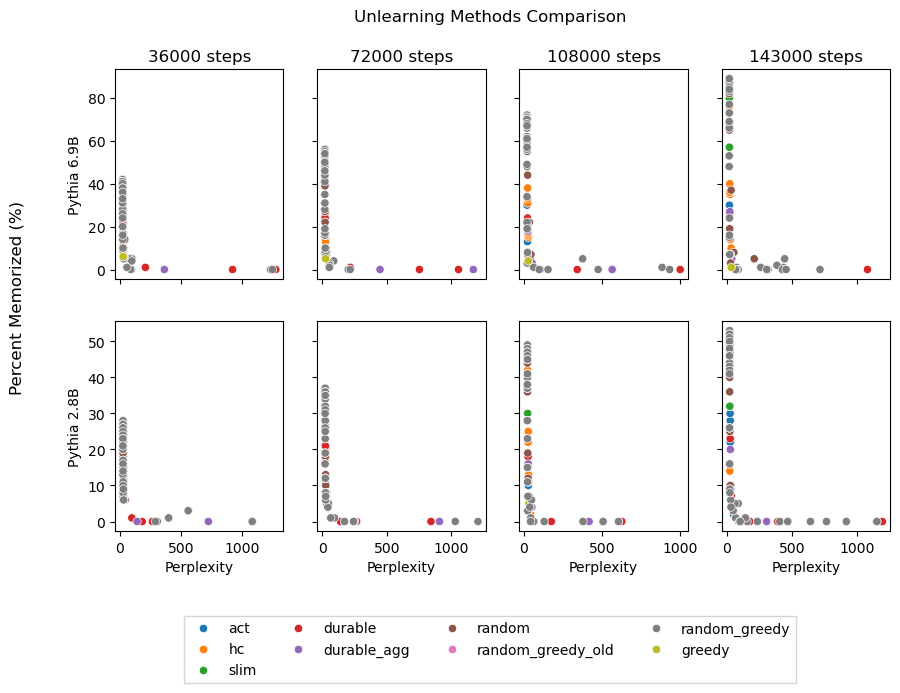

In [52]:
fig, axs = plt.subplots( 2, 4, sharex="col", sharey='row', figsize=(10,6))
fig.suptitle('Unlearning Methods Comparison')
fig.supylabel("Percent Memorized (%)")


y_idx = 0
x_idx = 0


dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        ax = sns.scatterplot(x="perp",
                y="perc",
                data=df,
                hue="localization_method", ax=axs[x_idx, y_idx])
        ax.set_xlabel("Perplexity")
        #ax.set_ylabel("Percent Difference in Memorization Post-Edit (%)")
        ax.get_legend().remove()

        print(y_idx, x_idx)
        y_idx += 1
    x_idx += 1

rows = ["Pythia 6.9B", "Pythia 2.8B"]
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

cols = [36000, 72000, 108000, 143000]
for ax, col in zip(axs[0], cols):
    ax.set_title(f'{col} steps')
        #plt.show()

#fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_localization_hp_scatter_plot.pdf", bbox_inches='tight')

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
0 0
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
1 0
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
2 0
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
3 0
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
0 1
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
1 1
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
2 1
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
3 1


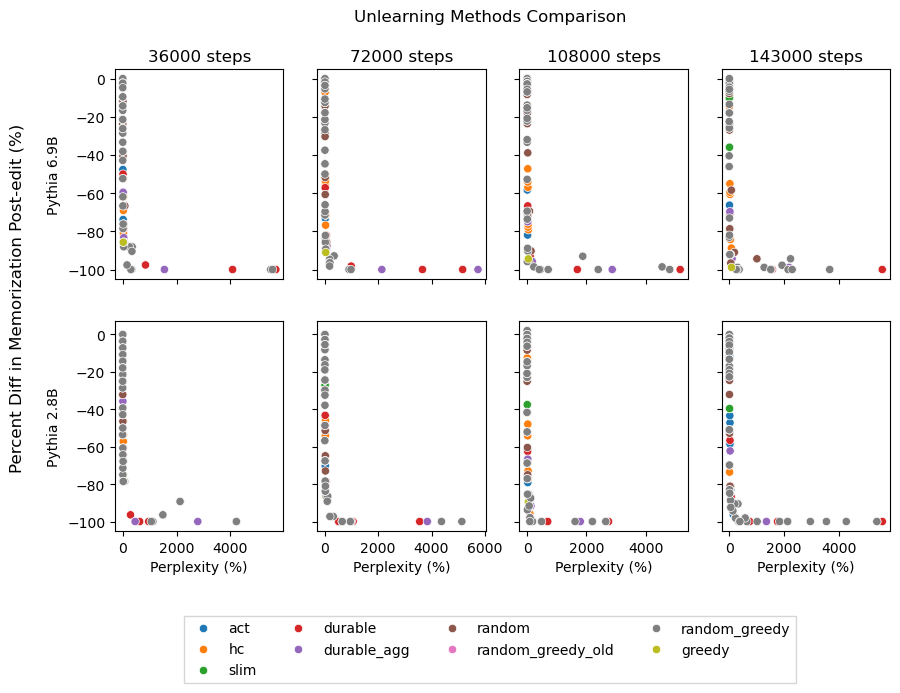

In [53]:
fig, axs = plt.subplots( 2, 4, sharex="col", sharey='row', figsize=(10,6))
fig.suptitle('Unlearning Methods Comparison')
fig.supylabel("Percent Diff in Memorization Post-edit (%)")


y_idx = 0
x_idx = 0


dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = generate_perc_diffs(df, base_stats)
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        ax = sns.scatterplot(x="perp_diff",
                y="perc_diff",
                data=df,
                hue="localization_method", ax=axs[x_idx, y_idx])
        ax.set_xlabel("Perplexity (%)")
        #ax.set_ylabel("Percent Difference in Memorization Post-Edit (%)")
        ax.get_legend().remove()

        print(y_idx, x_idx)
        y_idx += 1
    x_idx += 1

rows = ["Pythia 6.9B", "Pythia 2.8B"]
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

cols = [36000, 72000, 108000, 143000]
for ax, col in zip(axs[0], cols):
    ax.set_title(f'{col} steps')
        #plt.show()

#fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_localization_hp_scatter_plot.pdf", bbox_inches='tight')

In [54]:
# add in timing for all of the

def fill_in_neuron_time(df):
  # we are just filtering out things that were accidentally included in the HP sweep that shouldn't have been
  mask = (df.localization_method.isin(["hc","random_greedy","random","hc","slim","ig"])) & (df.batch_size == 512)
  df = df[~mask]
  # filter batch size of
  # no hp: zero, act, ig
  #print("hello")
  df.drop(df[(df.localization_method =="ig") & (df.batch_size == 512)].index, inplace=True)
  for model_name in ["EleutherAI/pythia-2.8b-deduped", "EleutherAI/pythia-6.9b-deduped"]:
      for localization_method in ['zero', 'act', 'ig']:
        if localization_method in list(df['localization_method']):
          time = df[(df['localization_method']==localization_method) & (df['total_time'] > 0) & (df['model_name'] == model_name) ].total_time.item()
          #print(time)
          df.loc[(df['localization_method']==localization_method) & (df['total_time'].isna()& (df['model_name'] == model_name)), 'total_time'] = time

      # epoch: hc, slim
      for localization_method in ['hc', 'slim']:
        if localization_method in list(df['localization_method']):
          for epochs in [1, 10, 20]:
            if epochs in list(df[(df['localization_method']==localization_method)].epochs):
              time = df[(df['localization_method']==localization_method) & (df['total_time'] > 0) & (df['epochs']==epochs)& (df['model_name'] == model_name)].total_time.item()
              df.loc[(df['localization_method']==localization_method) &  (df['epochs']==epochs) &(df['total_time'].isna()& (df['model_name'] == model_name)), 'total_time'] = time

  return df

In [59]:
dfs = []
best_dfs = []
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        df = fill_in_neuron_time(df)
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        df = grab_valid_experiments(df)
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = generate_perc_diffs(df, base_stats)
        df = df.drop_duplicates()
        dfs.append(copy.deepcopy(df))

        df = return_ideal_method_for_lang(base_stats, df, perp_cutoff= 500, mem_cutoff=10, backdoor=False)
        best_dfs.append(copy.deepcopy(df))
        print(df)
        #print(df.to_latex(index=False))

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
(167, 92)
total finished: 152/152
(153, 93)
     perc  perp localization_method  ratio epochs loss_weighting   total_time
3    42.0  22.0          BASE_STATS    0.1    1.0           0.05    10.007435
305   6.0  26.0              greedy  0.001    1.0           0.05  36681.92987
52    9.0  28.0             durable   0.01    1.0           0.05     6.451955
59    7.0  30.0         durable_agg   0.01    1.0           0.05   560.031209
118  10.0  28.0              random    5.0   10.0           0.05   235.290785
254   9.0  24.0       random_greedy    5.0    1.0            0.7    214.57831
31    8.0  27.0                  hc    5.0    1.0           0.05     3.368649
47   37.0  23.0                slim    5.0    1.0           0.05     2.783565
48   37.0  23.0                slim    5.0   10.0           0.05    25.076685
49   37.0  23.0                slim    5.0   20.0           0.05    49.979251
9     8.0  26.0                 act    

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.8571428571428571' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


(153, 92)
     perc   perp localization_method  ratio epochs loss_weighting  \
3    56.0   20.0          BASE_STATS    0.1    1.0           0.05   
305   5.0   26.0              greedy  0.001    1.0           0.05   
53    1.0  217.0             durable    0.1    1.0           0.05   
59    7.0   35.0         durable_agg   0.01    1.0           0.05   
116   9.0   25.0              random    1.0   20.0           0.05   
254   8.0   23.0       random_greedy    5.0    1.0            0.7   
31   13.0   25.0                  hc    5.0    1.0           0.05   
47   48.0   21.0                slim    5.0    1.0           0.05   
48   48.0   21.0                slim    5.0   10.0           0.05   
49   48.0   21.0                slim    5.0   20.0           0.05   
9     9.0   25.0                 act    5.0    1.0           0.05   

       total_time  
3       13.048762  
305  36533.942792  
53       7.794687  
59     435.648617  
116    485.543025  
254    219.600122  
31       4.357563  
4

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9107142857142857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


total finished: 152/152
(153, 87)
     perc  perp localization_method  ratio epochs loss_weighting    total_time
4    72.0  19.0          BASE_STATS    0.1    1.0           0.05     16.487558
369   4.0  27.0              greedy  0.001    1.0           0.05  36551.634103
53    5.0  38.0             durable   0.01    1.0           0.05       8.86209
59    3.0  52.0         durable_agg   0.01    1.0           0.05    446.663991
116   3.0  30.0              random    1.0   20.0           0.05     617.84856
229   3.0  20.0       random_greedy    0.1   10.0            0.7   1566.908354
34   16.0  25.0                  hc    5.0   10.0           0.05      47.25092
48   56.0  20.0                slim    5.0    1.0           0.05      4.575929
49   56.0  20.0                slim    5.0   10.0           0.05     42.546015
50   56.0  20.0                slim    5.0   20.0           0.05     84.580761
9     7.0  25.0                 act    5.0    1.0           0.05     16.487558
STEP:  143000  mod

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9444444444444444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


total finished: 152/152
(153, 86)
     perc  perp localization_method  ratio epochs loss_weighting    total_time
5    89.0  19.0          BASE_STATS    0.1    1.0           0.05     20.546512
369   1.0  34.0              greedy  0.001    1.0           0.05  36314.376103
53    6.0  33.0             durable   0.01    1.0           0.05     10.247648
60    5.0  38.0         durable_agg   0.01    1.0           0.05    438.042559
116   3.0  29.0              random    1.0   10.0           0.05    414.953092
255   7.0  22.0       random_greedy    5.0    1.0            0.7    233.418606
36   14.0  26.0                  hc    5.0   10.0           0.05     58.325949
49   57.0  20.0                slim    5.0    1.0           0.05      5.653414
50   57.0  20.0                slim    5.0   10.0           0.05     53.213958
51   57.0  20.0                slim    5.0   20.0           0.05    104.852026
10    7.0  25.0                 act    5.0    1.0           0.05     20.546512
STEP:  36000  mode

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9887640449438202' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


total finished: 152/152
(152, 93)
    perc  perp localization_method  ratio epochs loss_weighting   total_time
0     28  25.0          BASE_STATS    0.1      1           0.05     4.345152
246    7  29.0              greedy  0.001      1           0.05  7554.992594
37     1  97.0             durable    0.1      1           0.05     3.163774
50     6  36.0         durable_agg   0.01      1           0.05   206.961868
76     9  28.0              random    5.0     10           0.05    69.156241
339    7  26.0       random_greedy    0.1     20            0.7  1118.058532
15     6  31.0                  hc    5.0      1           0.05     1.434162
29    25  25.0                slim    5.0      1           0.05     1.639816
30    25  25.0                slim    5.0     10           0.05     9.228662
32    25  25.0                slim    5.0     20           0.05    18.621565
5      6  31.0                 act    5.0      1           0.05     4.345152
STEP:  72000  model_name:   EleutherAI/pyt

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


total finished: 152/152
(152, 92)
    perc  perp localization_method  ratio epochs loss_weighting   total_time
0     37  23.0          BASE_STATS    0.1      1           0.05     5.466582
246    5  30.0              greedy  0.001      1           0.05  7634.340023
35     8  33.0             durable   0.01      1           0.05     3.573657
50     4  45.0         durable_agg   0.01      1           0.05   238.479782
78     8  32.0              random   10.0      1           0.05    35.157534
343    6  26.0       random_greedy    0.1     20            0.5  1139.240483
15     5  33.0                  hc    5.0      1           0.05      1.65815
29    27  24.0                slim    5.0      1           0.05     1.922565
30    27  24.0                slim    5.0     10           0.05    12.177043
32    27  24.0                slim    5.0     20           0.05    24.077857
5      7  29.0                 act    5.0      1           0.05     5.466582
STEP:  108000  model_name:   EleutherAI/py

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.8648648648648649' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


total finished: 152/152
(152, 87)
    perc  perp localization_method  ratio epochs loss_weighting   total_time
0     48  22.0          BASE_STATS    0.1      1           0.05     6.889188
243    5  31.0              greedy  0.001      1           0.05  7629.929849
35     7  36.0             durable   0.01      1           0.05     4.419891
47     4  50.0         durable_agg   0.01      1           0.05   166.996693
78     6  39.0              random   10.0      1           0.05     36.59575
335    3  24.0       random_greedy    0.1     10            0.7   604.821326
15     2  42.0                  hc    5.0      1           0.05     2.100143
28    30  23.0                slim    5.0      1           0.05     2.227431
30    30  23.0                slim    5.0     10           0.05    15.885573
31    30  23.0                slim    5.0     20           0.05    30.888106
2     16  24.0                 act    1.0      1           0.05     6.889188
STEP:  143000  model_name:   EleutherAI/py

/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.8958333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


total finished: 152/152
(152, 86)
    perc  perp localization_method  ratio epochs loss_weighting   total_time
0     53  21.0          BASE_STATS    1.0      1           0.05     2.484289
244    4  32.0              greedy  0.001      1           0.05  7545.783458
35     7  35.0             durable   0.01      1           0.05     4.504877
48     5  48.0         durable_agg   0.01      1           0.05    231.42938
79     1  72.0              random   10.0      1           0.05    37.495288
346    9  23.0       random_greedy    1.0      1            0.7    88.970247
17     9  31.0                  hc    5.0     10           0.05    18.236757
28    32  23.0                slim    5.0      1           0.05     1.981384
29    32  23.0                slim    5.0     10           0.05    17.367561
31    32  23.0                slim    5.0     20           0.05    34.429817
4      9  27.0                 act    5.0      1           0.05     7.986578


/tmp/ipykernel_1529543/2689390383.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9245283018867925' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


In [103]:
best_df = pd.concat(best_dfs, axis=0, ignore_index=True)

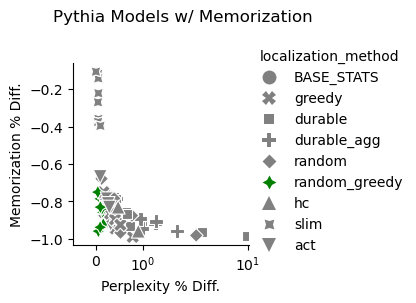

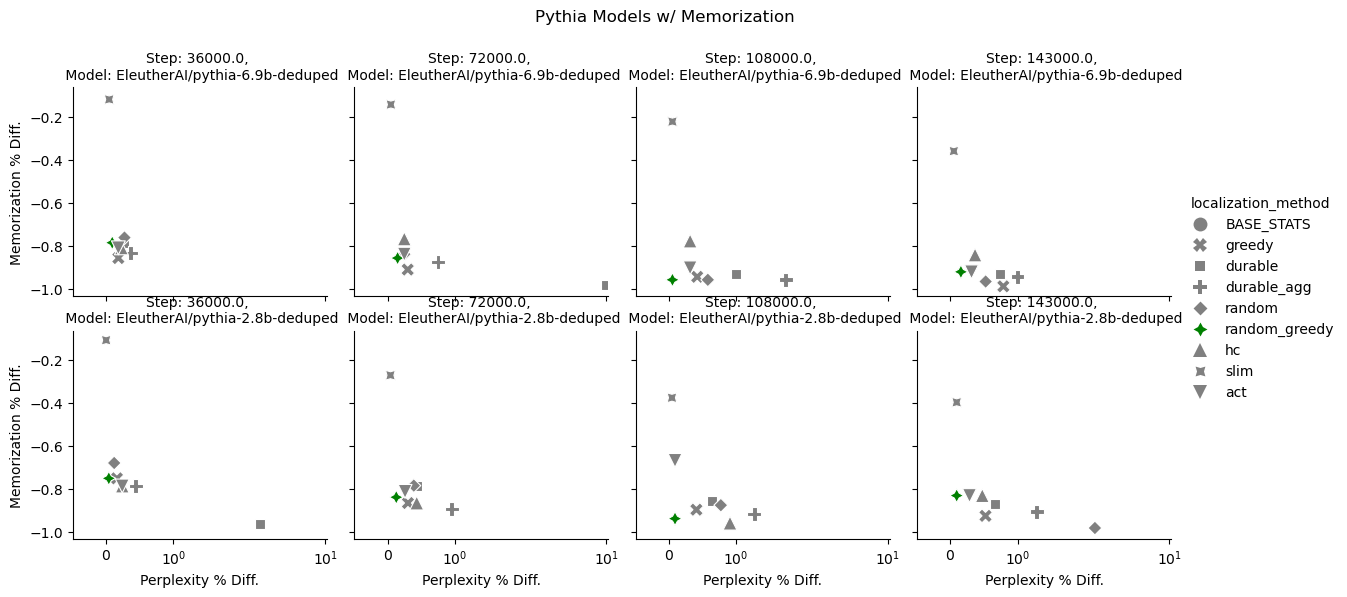

In [104]:
palette = {
    method: color if method != "random_greedy" else "green"
    for method, color in zip(best_df.localization_method.unique(), ["grey"]*11)
}
p = sns.relplot(
    best_df,
    kind="scatter",
    #col="model_name",
    #row="step",
    x="perp_diff",
    y="perc_diff",
    hue="localization_method",
    palette=palette,
    style="localization_method",
    s=100,
    #alpha=0.5,
    markers=True,
    height=3, aspect=1,
).set(xscale="symlog", yscale="linear")
#p.set_titles("Step: {col_name}, \n Model: {row_name}")
p.set_ylabels("Memorization % Diff.", clear_inner=False)
p.set_xlabels("Perplexity % Diff.", clear_inner=False)
p.fig.suptitle('Pythia Models w/ Memorization')
p.fig.subplots_adjust(top=.8)
plt.show()
p.savefig('pythia_scatter.pdf')

p = sns.relplot(
    best_df,
    kind="scatter",
    row="model_name",
    col="step",
    x="perp_diff",
    y="perc_diff",
    hue="localization_method",
    palette=palette,
    style="localization_method",
    s=100,
    #alpha=0.5,
    markers=True,
    height=3, aspect=1,
).set(xscale="symlog", yscale="linear")
p.set_titles("Step: {col_name}, \n Model: {row_name}")
p.set_ylabels("Memorization % Diff.", clear_inner=False)
p.set_xlabels("Perplexity % Diff.", clear_inner=False)
p.fig.suptitle('Pythia Models w/ Memorization')
p.fig.subplots_adjust(top=.85)
plt.show()
p.savefig('pythia_grid_scatter.pdf')

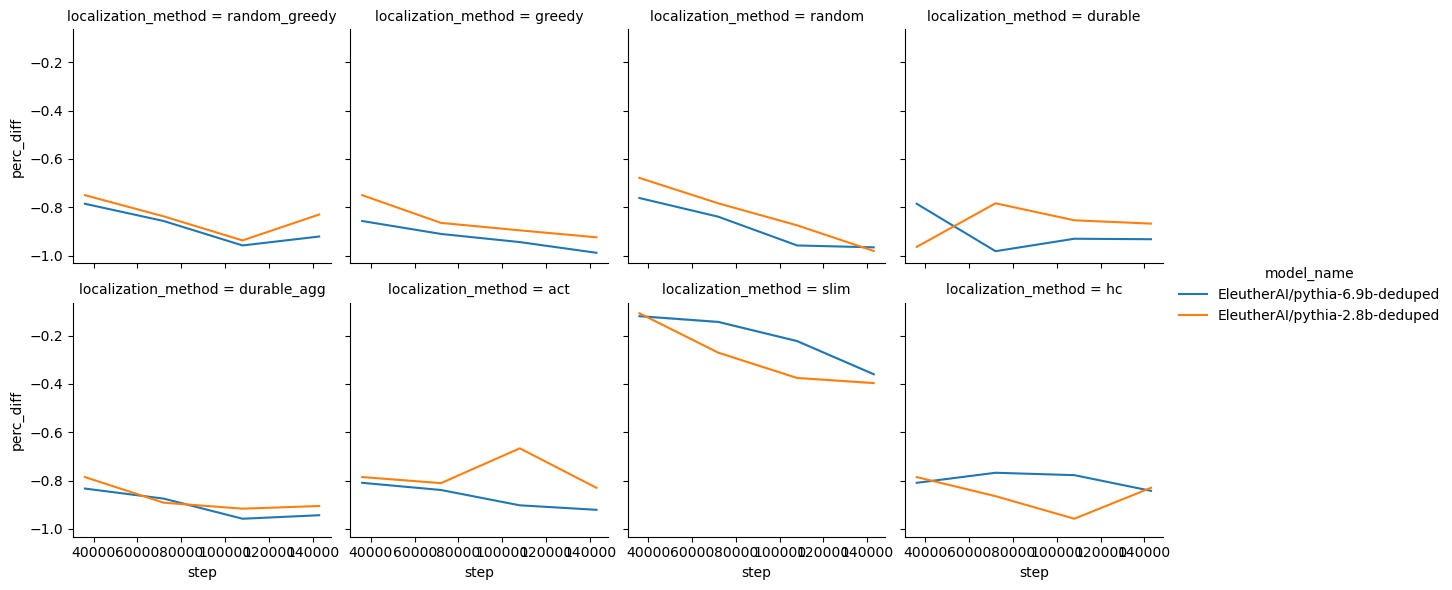

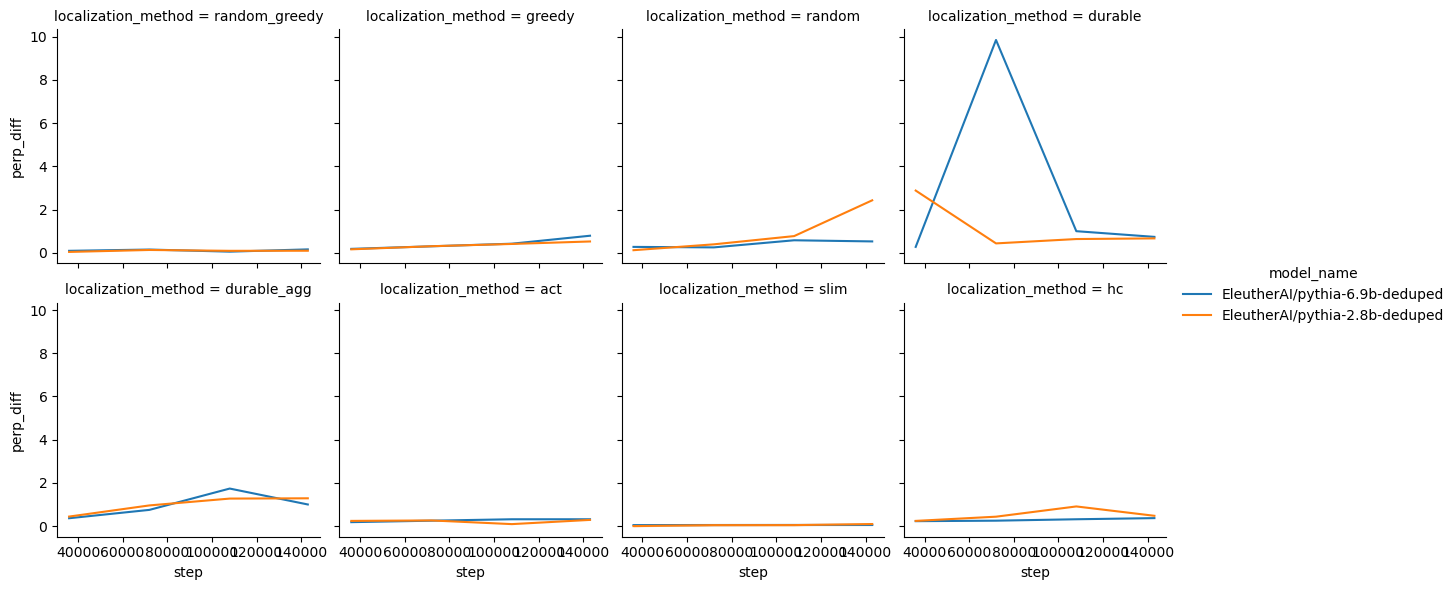

In [105]:
sns.relplot(
    data=best_df,
    x="step",
    y="perc_diff",
    hue="model_name",
    col="localization_method",
    col_wrap=4,
    kind="line",
    height=3, aspect=1,
    col_order=['random_greedy','greedy','random','durable','durable_agg','act','slim','hc'],

)
plt.show()

sns.relplot(
    data=best_df,
    x="step",
    y="perp_diff",
    hue="model_name",
    col="localization_method",
    col_wrap=4,
    kind="line",
    height=3, aspect=1,
    col_order=['random_greedy','greedy','random','durable','durable_agg','act','slim','hc'],

)
plt.show()

Text(0.5, 1.0, 'Unlearning method comparision accorss models + timepoints')

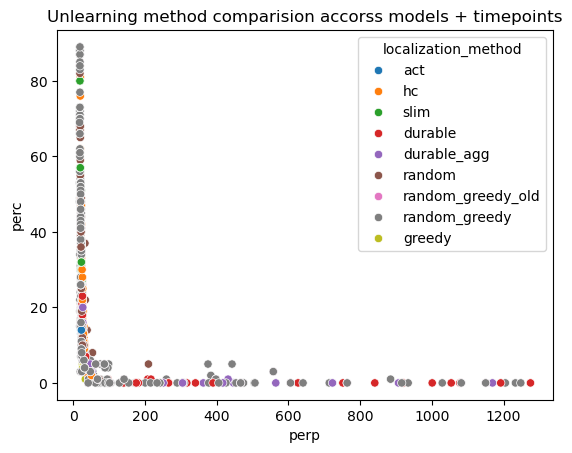

In [106]:
super_df = pd.concat(dfs, axis=0, ignore_index=True)
sns.scatterplot(x="perp",
                y="perc",
                data=super_df,
                hue="localization_method")
plt.title("Unlearning method comparision accorss models + timepoints")

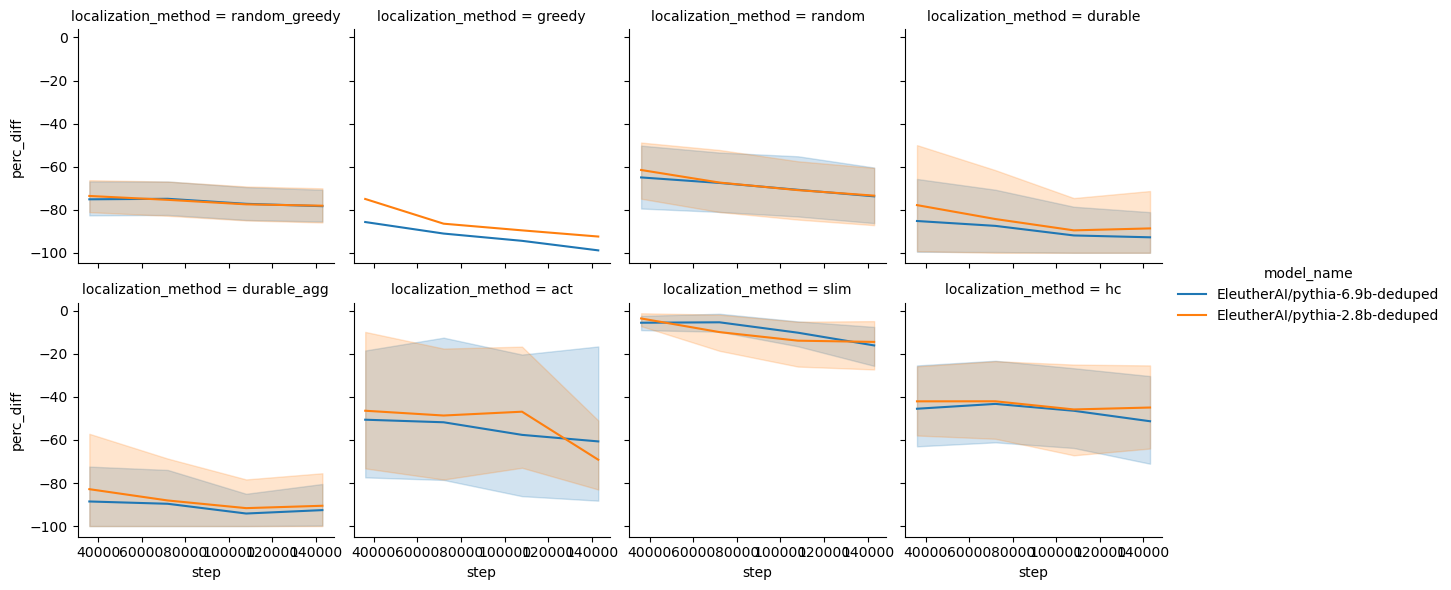

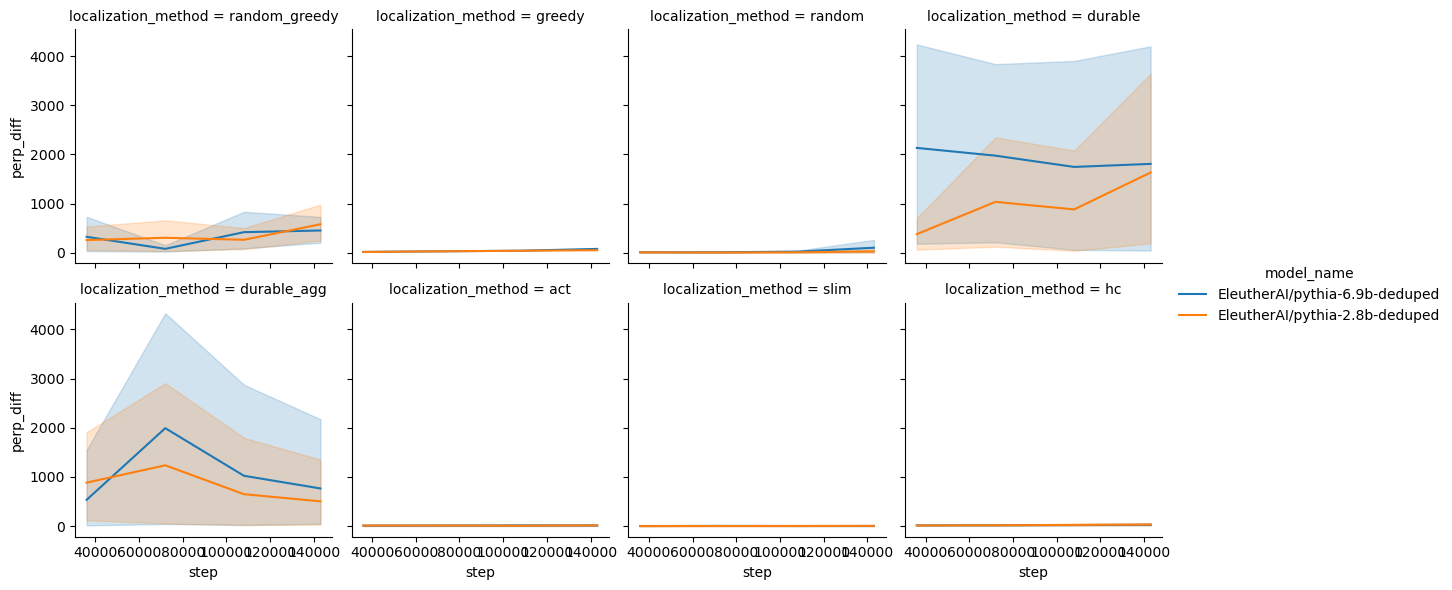

In [107]:
sns.relplot(
    data=super_df,
    x="step",
    y="perc_diff",
    hue="model_name",
    col="localization_method",
    col_wrap=4,
    kind="line",
    height=3, aspect=1,
    col_order=['random_greedy','greedy','random','durable','durable_agg','act','slim','hc'],

)
plt.show()

sns.relplot(
    data=super_df,
    x="step",
    y="perp_diff",
    hue="model_name",
    col="localization_method",
    col_wrap=4,
    kind="line",
    height=3, aspect=1,
    col_order=['random_greedy','greedy','random','durable','durable_agg','act','slim','hc'],

)
plt.show()

In [108]:
super_df.columns

Index(['Unnamed: 0.69', 'Unnamed: 0.68', 'Unnamed: 0.67', 'Unnamed: 0.66',
       'Unnamed: 0.65', 'Unnamed: 0.64', 'Unnamed: 0.63', 'Unnamed: 0.62',
       'Unnamed: 0.61', 'Unnamed: 0.60', 'Unnamed: 0.59', 'Unnamed: 0.58',
       'Unnamed: 0.57', 'Unnamed: 0.56', 'Unnamed: 0.55', 'Unnamed: 0.54',
       'Unnamed: 0.53', 'Unnamed: 0.52', 'Unnamed: 0.51', 'Unnamed: 0.50',
       'Unnamed: 0.49', 'Unnamed: 0.48', 'Unnamed: 0.47', 'Unnamed: 0.46',
       'Unnamed: 0.45', 'Unnamed: 0.44', 'Unnamed: 0.43', 'Unnamed: 0.42',
       'Unnamed: 0.41', 'Unnamed: 0.40', 'Unnamed: 0.39', 'Unnamed: 0.38',
       'Unnamed: 0.37', 'Unnamed: 0.36', 'Unnamed: 0.35', 'Unnamed: 0.34',
       'Unnamed: 0.33', 'Unnamed: 0.32', 'Unnamed: 0.31', 'Unnamed: 0.30',
       'Unnamed: 0.29', 'Unnamed: 0.28', 'Unnamed: 0.27', 'Unnamed: 0.26',
       'Unnamed: 0.25', 'Unnamed: 0.24', 'Unnamed: 0.23', 'Unnamed: 0.22',
       'Unnamed: 0.21', 'Unnamed: 0.20', 'Unnamed: 0.19', 'Unnamed: 0.18',
       'Unnamed: 0.17', '

In [109]:
df_w_all_prod_results = super_df[['model_name', 'localization_method',
       'ratio', 'batch_size', 'epochs', 'lambda_l1', 'stop_loss', 'lr',
       'prompt_len', 'ig_steps', 'momentum', 'weight_decay', 'step',
       'assess_mem', 'seed', 'loss_weighting',
       'perc', 'perp', 'total_time','perc_diff',
       'perp_diff']]

In [110]:
df_w_all_prod_results

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,...,weight_decay,step,assess_mem,seed,loss_weighting,perc,perp,total_time,perc_diff,perp_diff
0,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,42,22.0,10.007435,0.000000,0.000000
1,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,22,23.0,10.007435,-47.619048,4.545455
2,EleutherAI/pythia-6.9b-deduped,act,0.010,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,11,25.0,10.007435,-73.809524,13.636364
3,EleutherAI/pythia-6.9b-deduped,act,0.050,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,8,26.0,10.007435,-80.952381,18.181818
4,EleutherAI/pythia-6.9b-deduped,hc,0.001,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,37,23.0,3.368649,-11.904762,4.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,20,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.90,0,102.0,1188.774494,-100.000000,385.714286
1487,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,1,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.70,0,inf,89.209833,-100.000000,inf
1488,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,10,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.70,0,inf,610.129356,-100.000000,inf
1489,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,20,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.70,0,inf,1190.196697,-100.000000,inf


In [111]:
# Filter our "random_greedy_old"

df_w_all_prod_results = df_w_all_prod_results[df_w_all_prod_results.localization_method != "random_greedy_old"]

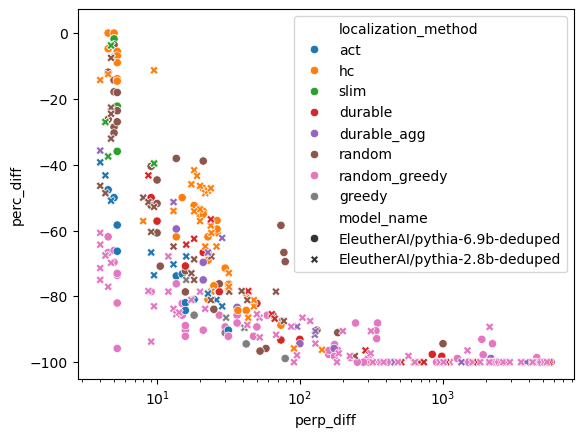

In [150]:
sns.scatterplot(data=df_w_all_prod_results, x="perp_diff", y="perc_diff", hue="localization_method", style="model_name")
plt.xscale('log')
#plt.yscale('log')

/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


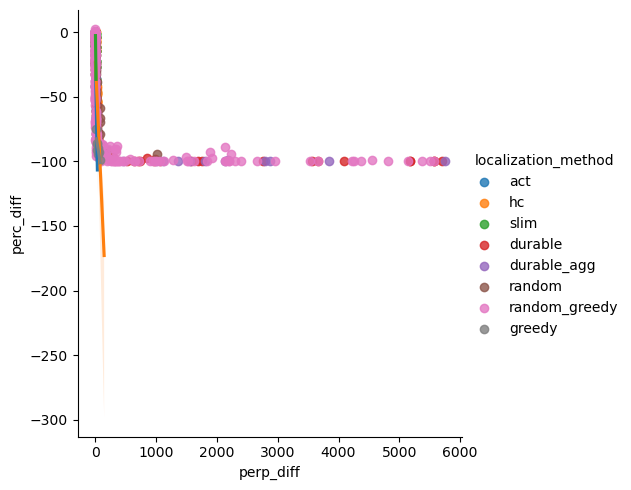

In [171]:
# plot 3 figure-level plot separated by species
g = sns.lmplot(data=df_w_all_prod_results, x="perp_diff", y="perc_diff", hue='localization_method')

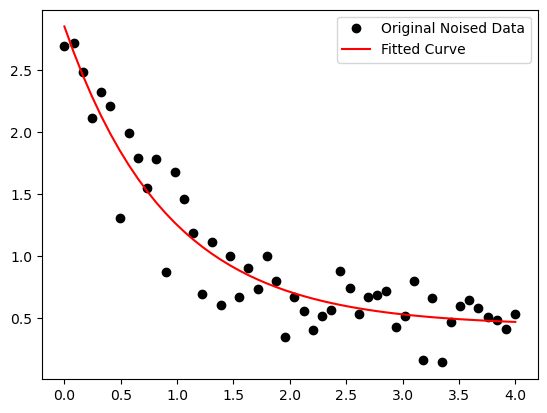

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.linspace(0,4,50)
y = func(x, 2.5, 1.3, 0.5)
yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, yn)

plt.figure()
plt.plot(x, yn, 'ko', label="Original Noised Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

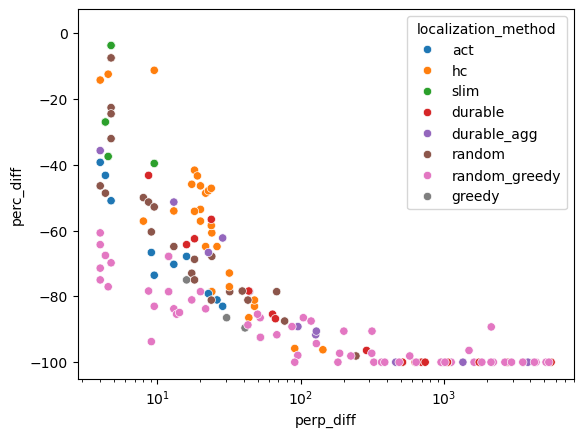

In [138]:
sns.scatterplot(data=df_w_all_prod_results[df_w_all_prod_results.model_name=="EleutherAI/pythia-2.8b-deduped"], x="perp_diff", y="perc_diff", hue="localization_method")
plt.xscale('log')
#plt.yscale('log')

/tmp/ipykernel_1036047/3801431164.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


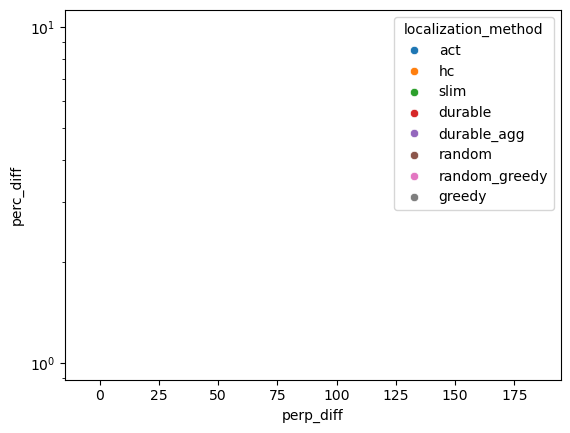

In [161]:
sns.scatterplot(data=df_w_all_prod_results[(df_w_all_prod_results.model_name=="EleutherAI/pythia-6.9b-deduped") & (df_w_all_prod_results.perp_diff<200)], x="perp_diff", y="perc_diff", hue="localization_method")
#plt.xscale('log')
#plt.yscale('log')

<Axes: xlabel='perp_diff', ylabel='localization_method'>

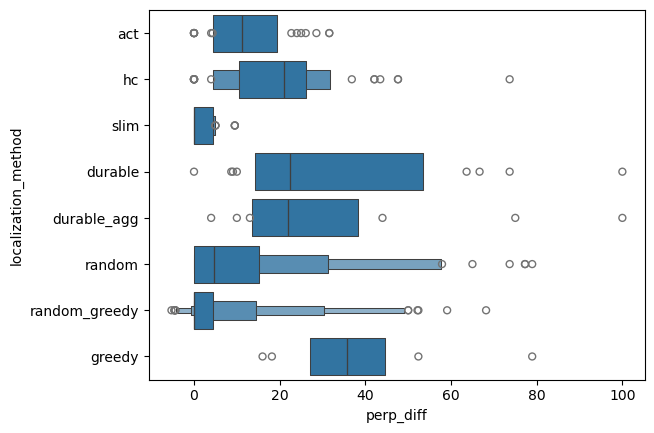

In [112]:
sns.boxenplot(y="localization_method", x="perp_diff", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)])

<Axes: xlabel='perc_diff', ylabel='localization_method'>

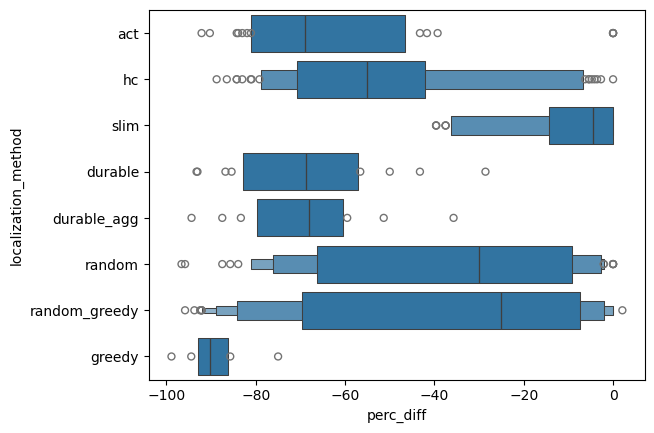

In [113]:
sns.boxenplot(y="localization_method", x="perc_diff", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)])

<Axes: xlabel='perp', ylabel='localization_method'>

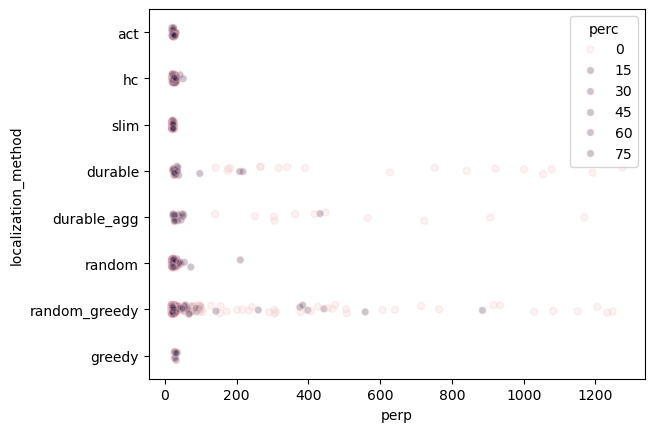

In [114]:
from matplotlib.colors import LogNorm, Normalize
sns.stripplot(y="localization_method", x="perp", data=df_w_all_prod_results, hue='perc', alpha=0.25, hue_norm=Normalize(0, 1, clip=True), linewidth=1, edgecolor="pink")

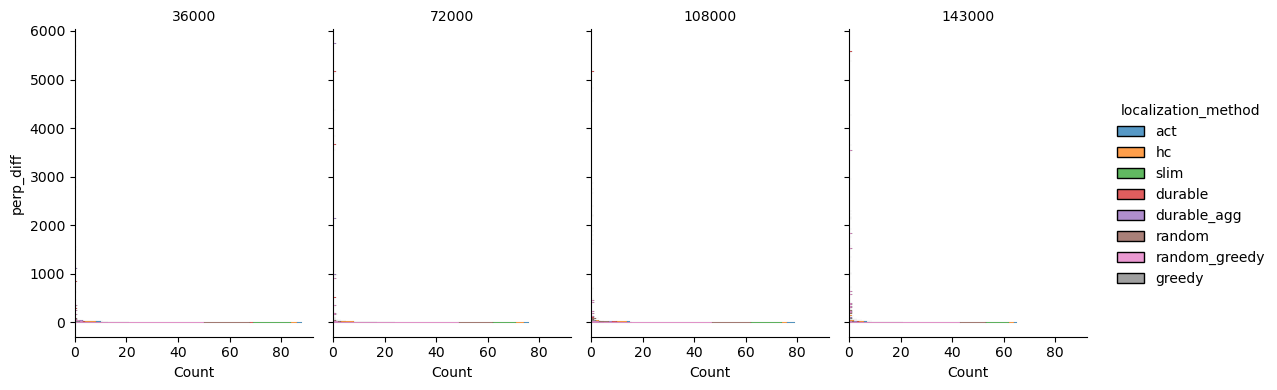

In [115]:
g = sns.displot(
     y="perp_diff", hue="localization_method", data=df_w_all_prod_results, col="step",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

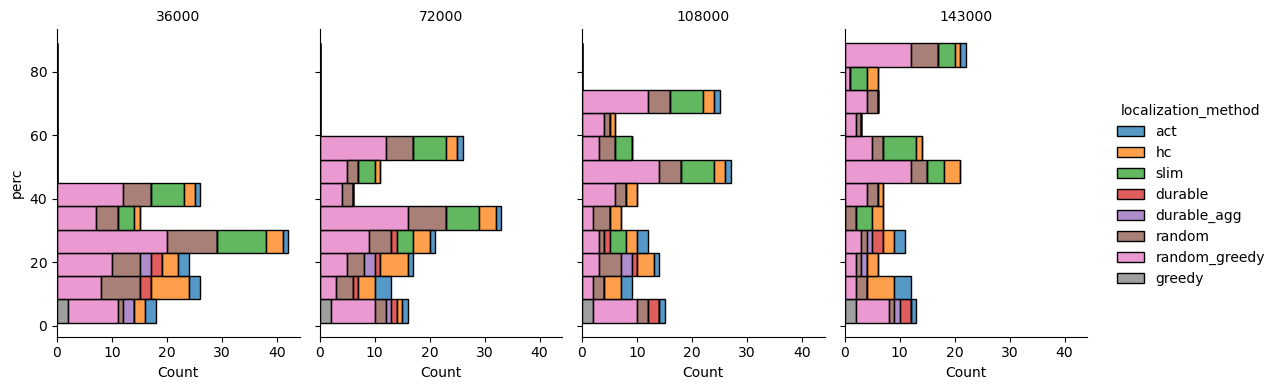

In [116]:
g = sns.displot(
     y="perc", hue="localization_method", data=df_w_all_prod_results[df_w_all_prod_results.perp < 40], col="step",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

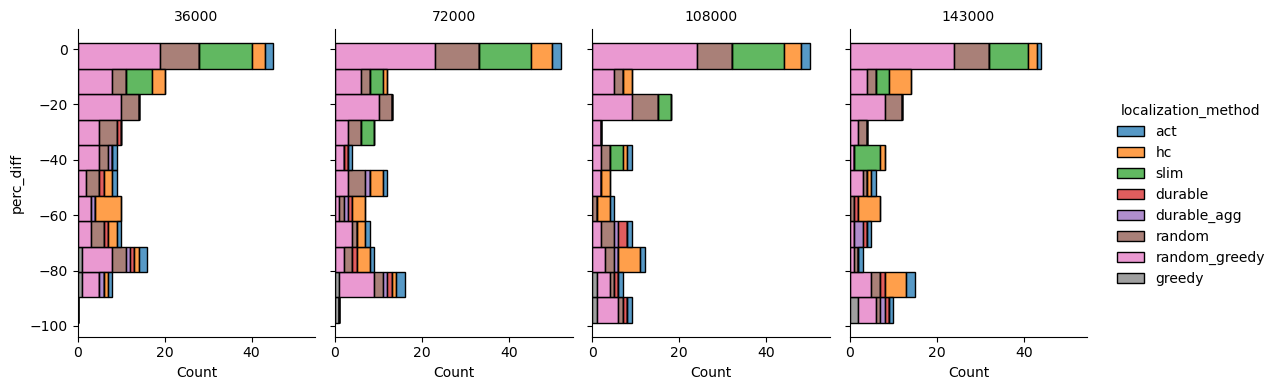

In [117]:
g = sns.displot(
     y="perc_diff", hue="localization_method", data=df_w_all_prod_results[df_w_all_prod_results.perp < 40], col="step",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

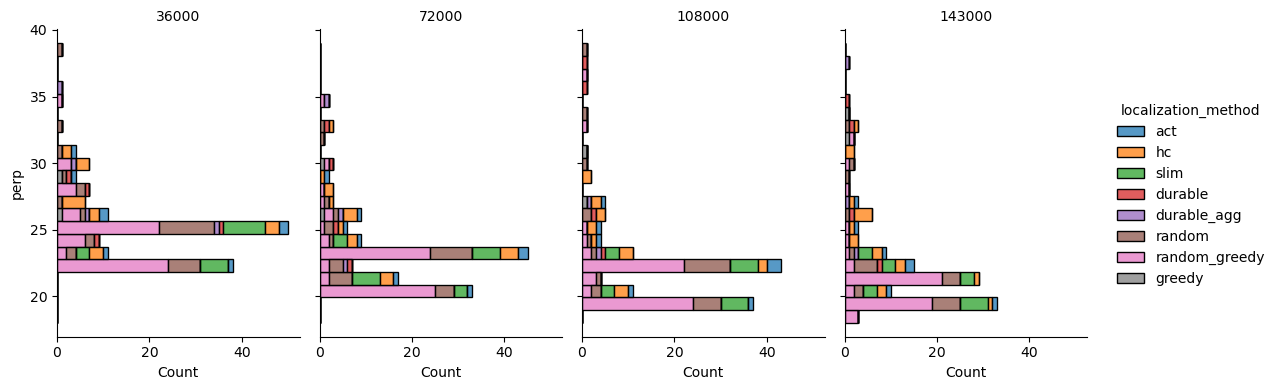

In [118]:
g = sns.displot(
     y="perp", hue="localization_method", data=df_w_all_prod_results[df_w_all_prod_results.perp < 40], col="step",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

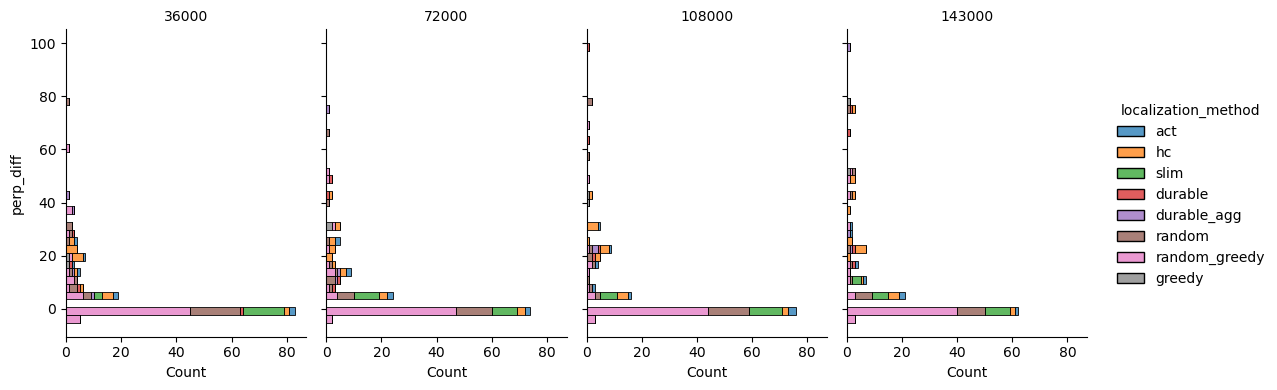

In [119]:
g = sns.displot(
     y="perp_diff", hue="localization_method", data=df_w_all_prod_results[df_w_all_prod_results.perp < 40], col="step",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

/tmp/ipykernel_1036047/2770447222.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(


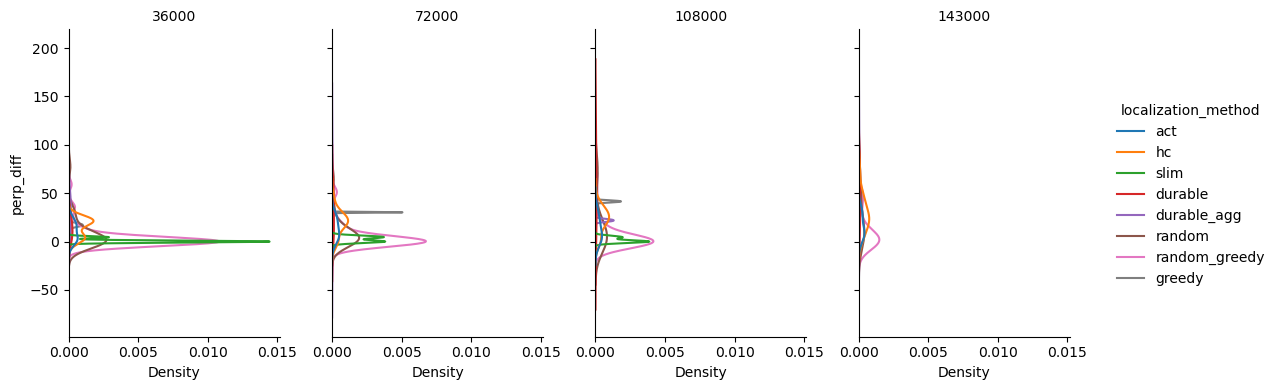

In [120]:
g = sns.displot(
     y="perp_diff", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)], col="step",
    kind="kde", height=4, aspect=.7,
)

g.set_titles("{col_name}")

/tmp/ipykernel_1036047/2235413226.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(


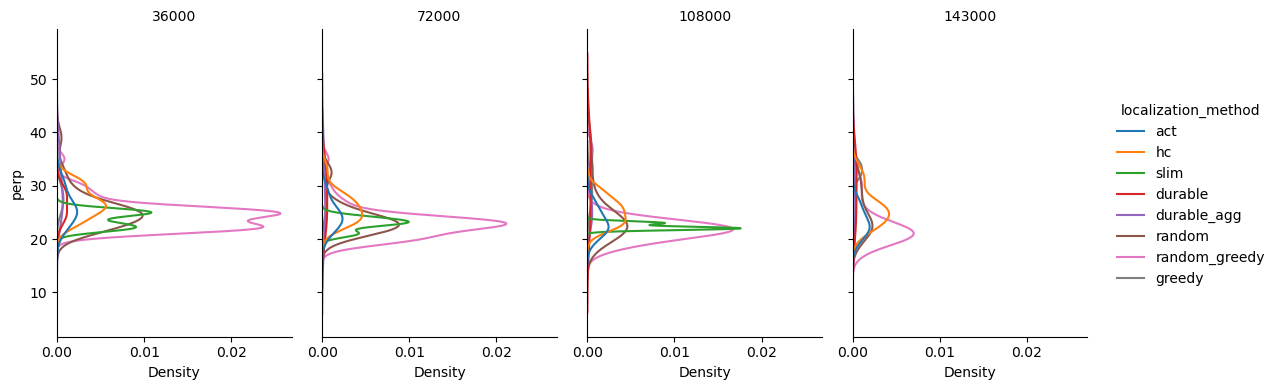

In [121]:
g = sns.displot(
     y="perp", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)], col="step",
    kind="kde", height=4, aspect=.7,
)

g.set_titles("{col_name}")

/tmp/ipykernel_1036047/3519668899.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(


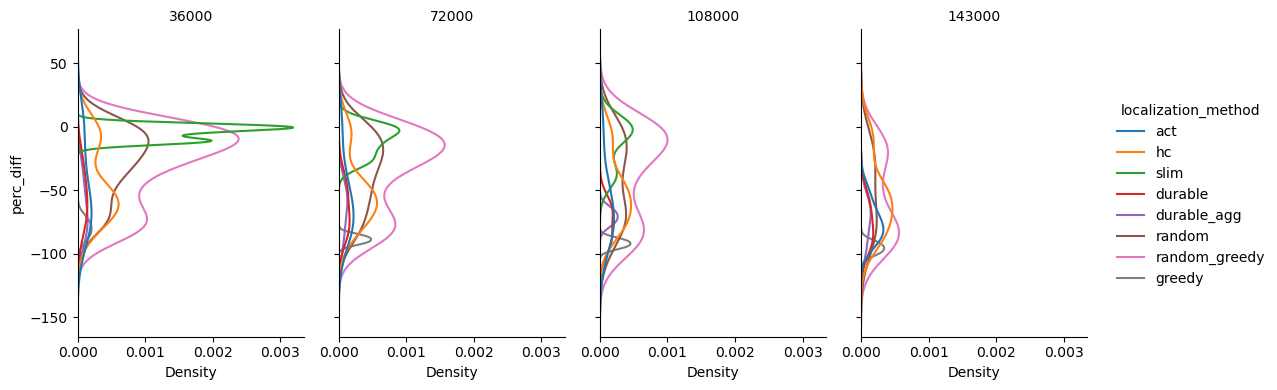

In [122]:
g = sns.displot(
     y="perc_diff", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)], col="step",
    kind="kde", height=4, aspect=.7,
)

g.set_titles("{col_name}")

/tmp/ipykernel_1036047/2358483287.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  p = sns.displot(


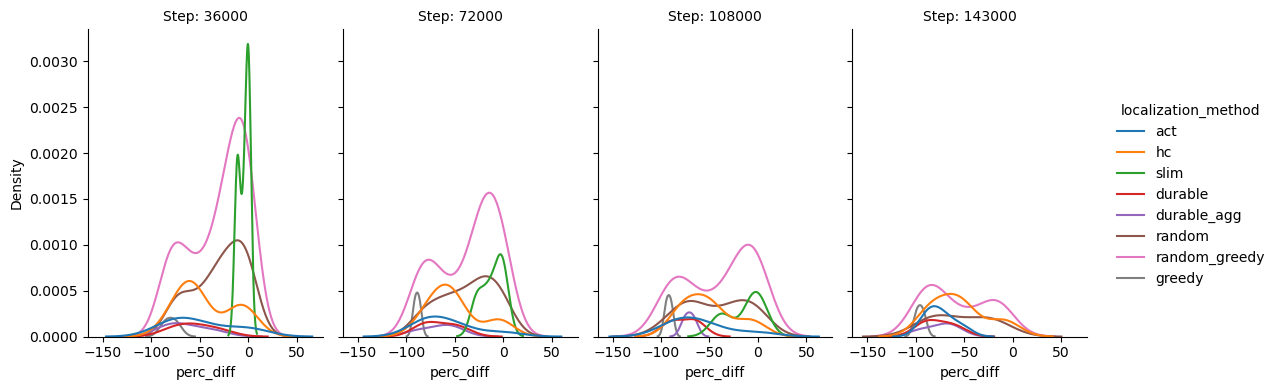

In [123]:
p = sns.displot(
     x="perc_diff", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)], col="step",
    kind="kde", height=4, aspect=.7,
)

p.set_titles("Step: {col_name}")

<Axes: xlabel='perc_diff', ylabel='Density'>

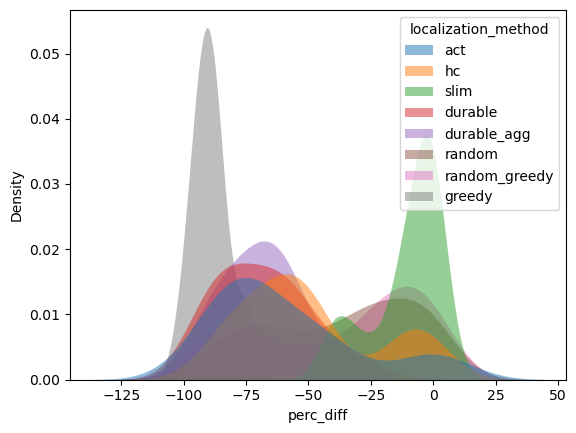

In [124]:
sns.kdeplot(
   x="perc_diff", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)],
   fill=True, common_norm=False, # palette="crest",
   alpha=.5, linewidth=0,
)

In [125]:
df_w_all_prod_results

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,...,weight_decay,step,assess_mem,seed,loss_weighting,perc,perp,total_time,perc_diff,perp_diff
0,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,42,22.0,10.007435,0.000000,0.000000
1,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,22,23.0,10.007435,-47.619048,4.545455
2,EleutherAI/pythia-6.9b-deduped,act,0.010,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,11,25.0,10.007435,-73.809524,13.636364
3,EleutherAI/pythia-6.9b-deduped,act,0.050,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,8,26.0,10.007435,-80.952381,18.181818
4,EleutherAI/pythia-6.9b-deduped,hc,0.001,32,1,1000,0.1,0.1,32,1,...,0.0005,36000,0,0,0.05,37,23.0,3.368649,-11.904762,4.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,20,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.90,0,102.0,1188.774494,-100.000000,385.714286
1487,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,1,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.70,0,inf,89.209833,-100.000000,inf
1488,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,10,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.70,0,inf,610.129356,-100.000000,inf
1489,EleutherAI/pythia-2.8b-deduped,random_greedy,0.100,32,20,1000,0.1,0.1,32,1,...,0.0005,143000,0,0,0.70,0,inf,1190.196697,-100.000000,inf


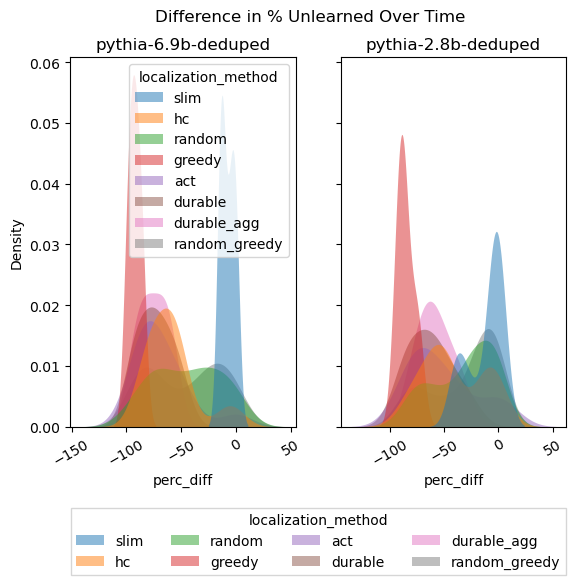

In [126]:
fig, axs = plt.subplots( 1,2, sharey=True)
fig.suptitle('Difference in % Unlearned Over Time')
model_names = ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]
for i in range(len(model_names)):
    model_name = model_names[i]
    df_w_name = df[df['model_name'] == model_name]
    #ax = sns.lineplot(data=data_w_name, x="epoch", y="train_loss", hue="n_layer", palette="Set2", ax=axs[i])
    ax = sns.kdeplot(
       x="perc_diff", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)& (df_w_all_prod_results.model_name == f'EleutherAI/{model_name}')],
       fill=True, 
        common_norm=False, # palette="crest",
       alpha=.5, linewidth=0,
      hue_order=["slim", "hc","random",'greedy', 'act', 'durable', 'durable_agg', "random_greedy"],
        legend = 1,
         ax=axs[i],
    )
    ax.set_title(f'{model_name}')
    #ax.get_legend().remove()
    ax.tick_params(axis='x', rotation=30)
handles, labels = ax.get_legend_handles_labels()
sns.move_legend(axs[1], loc='upper center', ncol=4, bbox_to_anchor=(-0.1, -0.2),fancybox=False, shadow=False)
#fig.legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=2)
plt.savefig(f"pythia_compare_localization_over_time_plot.pdf", bbox_inches='tight')

/tmp/ipykernel_1036047/1455730116.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(
/tmp/ipykernel_1036047/1455730116.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(
/tmp/ipykernel_1036047/1455730116.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(
/tmp/ipykernel_1036047/1455730116.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(
/tmp/ipykernel_1036047/1455730116.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(
/tmp/ipykernel_1036047/1455730116.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn

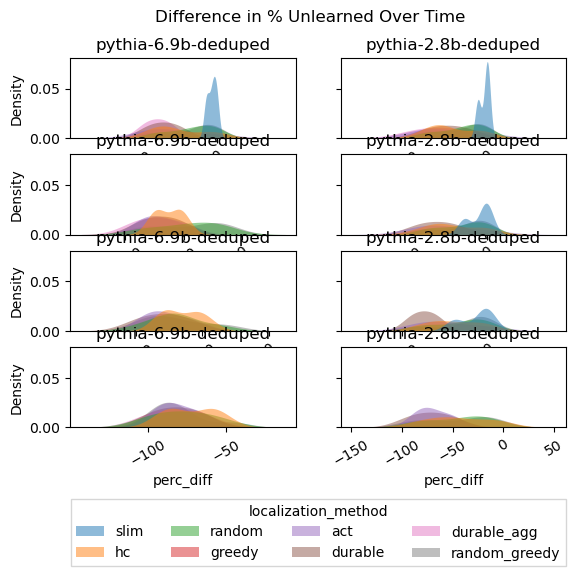

In [127]:
fig, axs = plt.subplots( 4,2, sharey=True)
fig.suptitle('Difference in % Unlearned Over Time')
model_names = ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]
steps = [36000, 72000, 108000, 143000]
for j in range(len(steps)):
    for i in range(len(model_names)):
        legend = 0
        if (i == 1) & (j == 3):
            legend = 1
        model_name = model_names[i]
        df_w_name = df[df['model_name'] == model_name]
        #ax = sns.lineplot(data=data_w_name, x="epoch", y="train_loss", hue="n_layer", palette="Set2", ax=axs[i])
        ax = sns.kdeplot(
           x="perc_diff", hue="localization_method", data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)& (df_w_all_prod_results.model_name == f'EleutherAI/{model_name}')& (df_w_all_prod_results.step == steps[j])],
           fill=True, 
            common_norm=False, # palette="crest",
           alpha=.5, linewidth=0,
          hue_order=["slim", "hc","random",'greedy', 'act', 'durable', 'durable_agg', "random_greedy"],
            legend = legend,
             ax=axs[ j, i],
        )
        ax.set_title(f'{model_name}')
        #ax.get_legend().remove()
        ax.tick_params(axis='x', rotation=30)
handles, labels = ax.get_legend_handles_labels()
sns.move_legend(axs[3,1], loc='upper center', ncol=4, bbox_to_anchor=(-0.1, -0.8),fancybox=False, shadow=False)
#fig.legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=2)

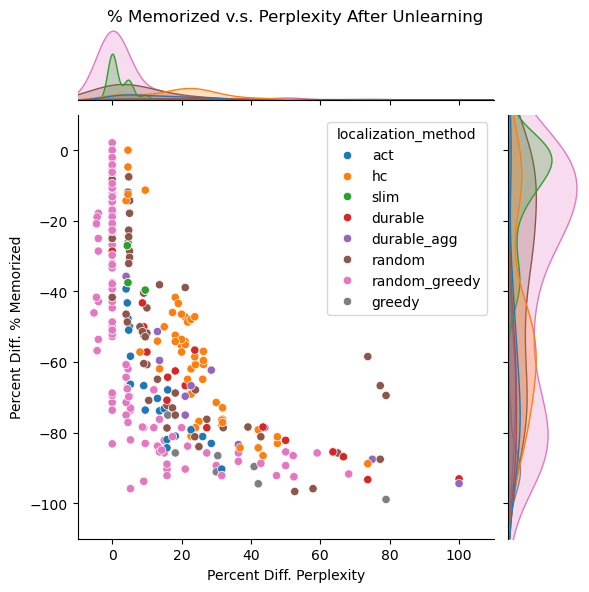

In [128]:
p = sns.jointplot( y="perc_diff", 
               x="perp_diff",
              hue="localization_method", 
              data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)],
              #kind="kde",
              xlim=(-10,110),
              ylim=(-110,10),
              #palette="Set2",
                 )
p.fig.suptitle("% Memorized v.s. Perplexity After Unlearning")
#p.fig.xlabel('Percent Diff. Perplexity')
p.ax_joint.set_ylabel('Percent Diff. % Memorized')
p.ax_joint.set_xlabel('Percent Diff. Perplexity')
p.fig.subplots_adjust(top=0.95)
plt.savefig(f"pythia_method_scatter_kde_plot.pdf", bbox_inches='tight')

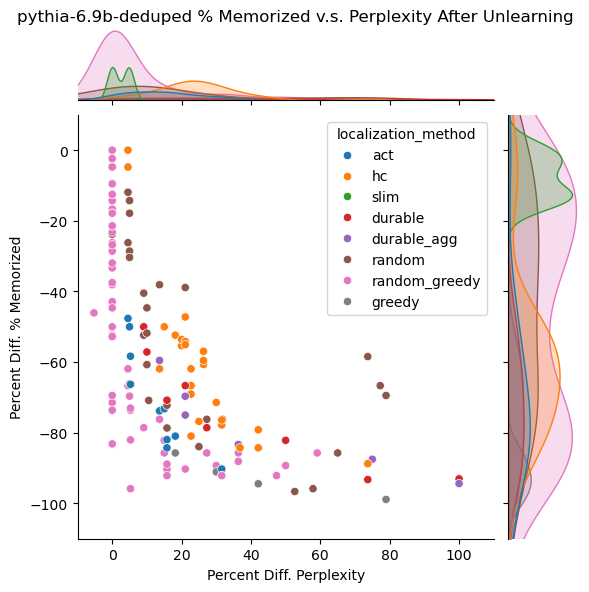

In [129]:
model_name = "pythia-6.9b-deduped"
p = sns.jointplot( y="perc_diff", 
               x="perp_diff",
              hue="localization_method", 
              data=df_w_all_prod_results[(df_w_all_prod_results.perp < 40) & (df_w_all_prod_results.perc < 50)& (df_w_all_prod_results.model_name == f'EleutherAI/{model_name}')],
              #kind="kde",
              xlim=(-10,110),
              ylim=(-110,10),
              #palette="Set2",
                 )
p.fig.suptitle(f"{model_name} % Memorized v.s. Perplexity After Unlearning")
#p.fig.xlabel('Percent Diff. Perplexity')
p.ax_joint.set_ylabel('Percent Diff. % Memorized')
p.ax_joint.set_xlabel('Percent Diff. Perplexity')
p.fig.subplots_adjust(top=0.95)
plt.savefig(f"pythia_method_scatter_kde_plot.pdf", bbox_inches='tight')

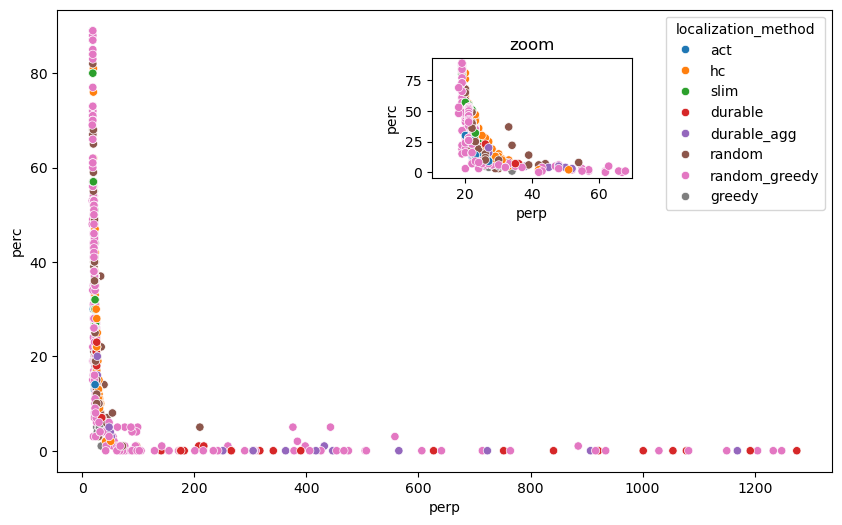

In [130]:
fig, axs = plt.subplots( 1, 1, sharex="col", sharey='row', figsize=(10,6))
sns.scatterplot(x="perp", y="perc", data=df_w_all_prod_results, hue='localization_method', ax=axs)

ax2 = plt.axes([0.5, 0.6, .2, .2])
sns.scatterplot(x="perp", y="perc", data=df_w_all_prod_results, hue='localization_method', ax=ax2)
ax2.set_title('zoom')
ax2.set_xlim([10,70])
ax2.get_legend().remove()

<Axes: xlabel='perp', ylabel='perc'>

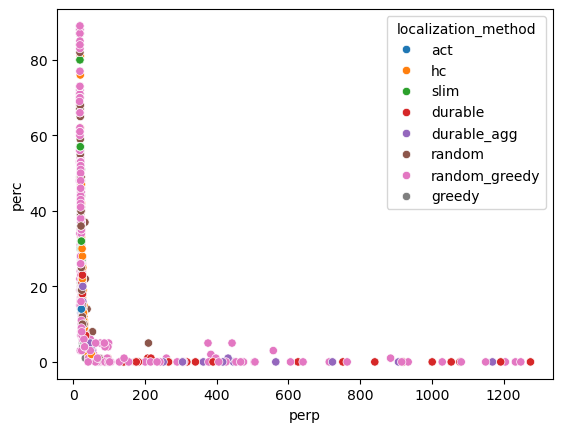

In [131]:
sns.scatterplot(x="perp", y="perc", data=df_w_all_prod_results, hue='localization_method')

# Unlearn Accross Time

In [132]:
seq_before = []
seq_after = []
ckpt_dir = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"
steps = [36000, 72000, 108000, 143000]
for step in steps:

    #load original mem set
    mem_seq_original = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
    seq_before.append(mem_seq_original)

    #load mem set after unlearning
    mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/act/mem/0.01/mem_seq_pythia-2.8b-deduped', map_location=torch.device('cpu'))
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/greedy/mem/1e-05/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/random_greedy/mem/0.01/1/0.1/0.9/0.0005/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/durable/mem/0.01/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
    seq_after.append(mem_seq_after_edit)

In [ ]:
for seq in seq_before:
    print(seq.shape)

In [ ]:
for seq in seq_after:
    if type(seq) == list:
        seq = torch.Tensor(seq)
    print(seq.shape)

In [ ]:
def get_common_mem_seq_at_all_time(seq_before):
    #bc we unlearn at different time points, we want to find a common subset of points that is memorized at each training set
    
    base_mem_seq = seq_before[0] # the earliest timepiont has fewest mem seqence
    common_seqs = []
    for row in base_mem_seq: #iterate thru all rows of base mem seq
        common = False
        for seq in seq_before: #see if later time points contain it
            if row in seq:
                common=True
                
        if common:
            common_seqs.append(copy.deepcopy(row.cpu()))
    
    return torch.stack(common_seqs, dim=0)

In [ ]:
common_seqs = get_common_mem_seq_at_all_time(seq_before)

In [ ]:
common_seqs.shape #there are 80 common seqences memorized at each time point (we will compare unlearning methods on these 80 sequences

In [ ]:
def check_overlap(seq_after, common_seqs, steps=steps):
    #Now we want to compare unlearning at multiple timepoints!
    not_unlearn_set_over_time = []
    for seq in seq_after:
        #print(seq.shape)
        #print(seq.shape)
        if type(seq) == list:
            seq = torch.Tensor(seq)
        seq = seq.to("cpu")
        not_unlearn_set = []
        count = 0
        #print(seq)
        #print(common_seqs)
        for row in seq:
            for c in common_seqs:
                if torch.equal(row, c):
                    #print("row not unlearned")
                    not_unlearn_set.append(copy.deepcopy(row))
                    count += 1
        #print("count: ", count)
        #print(torch.stack(not_unlearn_set, dim=0).shape)
        if not_unlearn_set != []:
            not_unlearned_set = torch.stack(not_unlearn_set, dim=0)
        else:
            not_unlearned_set = torch.Tensor([])
        not_unlearn_set_over_time.append(copy.deepcopy(not_unlearned_set))
        
    print("Common Mem seqence count: ", common_seqs.shape)
    
    perc_unlearns = {
        "step":[],
        "perc_unlearn":[]
    
    }
    for i in range(len(steps)):
        step = steps[i]
        #print("# of not unlearned seqences: ", not_unlearn_set_over_time[i].shape)
        perc_unlearn = 100 * (common_seqs.shape[0] - not_unlearn_set_over_time[i].shape[0])/ common_seqs.shape[0]
        #print(f"Perc unlearn @ step {step}: ", perc_unlearn, "%")
        perc_unlearns["step"].append(step)
        perc_unlearns["perc_unlearn"].append(perc_unlearn)
    
    return pd.DataFrame.from_dict(perc_unlearns) # we wnat to know how many of these sequenes were unlearned overtime
    

In [ ]:
check_overlap(seq_after, common_seqs)

Interestingly in the above setting, it appears the same unlearning method (act), unlearns worse at later timesteps, rather than earlier timesteps

In [ ]:
# interpret results!

# Iterate through all models (epochs)

In [ ]:
def print_edited_model_paths(parent_path):
    list_of_models = []
    dfs = []

    total_exp = 0
    for model_name in ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]:
        y_idx = 0
        for loc_method in [
            "act",
            "hc",
            "slim",
            "durable",
            "durable_agg",
            "random",
            "random_greedy",
            "greedy",
        ]: 
            for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3, 0.5, 0.8]:
                for epochs in [1, 10, 20]:
                    for loss_weight in [0.9, 0.7, 0.5,]:
                        
                        if epochs > 1:
                            if loc_method not in ["slim", "hc","random", "random_greedy"]:
                                continue
                        if loss_weight > 0.9:
                            if loc_method not in ["random_greedy"]:
                                continue
                        if loc_method not in ["random", "random_greedy"]:
                            if ratio >= 0.1:
                                continue

                        
                        seq_before = []
                        seq_after = []
                        steps = [36000, 72000, 108000, 143000]
                        for step in steps:
                            result_path = (
                                f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                            )


                            # this ratio is too small for neuron-level methods
                            if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                                if ratio <= 0.0001:
                                    continue

                            if loc_method in ["greedy"]:
                                if ratio > 0.00001:
                                    continue

                            ######
                            if loc_method in ["greedy", "durable", "durable_agg", "act"]:
                                model_path = f"{result_path}/{model_name}"
                                mem_seq_path = f"{result_path}/mem_seq_{model_name}"
                                total_exp += 1

                            if loc_method in ["slim", "hc"]:
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/1000/0.1/0.1/{model_name}"
                                    )
                                    mem_seq_path = model_path = (
                                        f"{result_path}/{epochs}/1000/0.1/0.1/mem_seq_{model_name}"
                                    )

                            if loc_method in ["random"]:
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}"
                                    )
                                    mem_seq_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/mem_seq_{model_name}"
                                    )

                            if loc_method in ["random_greedy"]:
                                    #print("random_greedy")
                                    total_exp += 1
                                    model_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{loss_weight}/{model_name}"
                                    )
                                    mem_seq_path = (
                                        f"{result_path}/{epochs}/0.1/0.9/0.0005/{loss_weight}/mem_seq_{model_name}"
                                    )

                            if os.path.isfile(model_path):
                                list_of_models.append(model_path)


                                #load original mem set
                                if "2" in model_name:
                                    mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
                                if "6" in model_name:
                                    mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
                                seq_before.append(mem_seq_original)

                                #load mem set after unlearning
                                mem_seq_after_edit = torch.load(mem_seq_path,map_location=torch.device('cpu'))
                                seq_after.append(mem_seq_after_edit)

                            else:
                                print("edited model doesn't exist yet: ", model_path)  
                                
                        if len(seq_before) == len(steps):
                            common_seqs = get_common_mem_seq_at_all_time(seq_before)
                            df = check_overlap(seq_after, common_seqs)
                            df.loc[:,"loc_method"] = loc_method
                            df.loc[:,"model_name"] = model_name
                            df.loc[:,"ratio"] = ratio
                            df.loc[:,"epochs"] = epochs
                            df.loc[:,"loss_weight"] = loss_weight
                            dfs.append(df)


    print("total_expeirments: ", total_exp)
    return list_of_models, pd.concat(dfs)

parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"

list_of_models, df =  print_edited_model_paths(parent_path)

In [ ]:
df.model_name.unique()

In [ ]:
fig, axs = plt.subplots( 1,2, sharey=True)
fig.suptitle('Difference in % Unlearned Over Time')
model_names = ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]
for i in range(len(model_names)):
    model_name = model_names[i]
    df_w_name = df[df['model_name'] == model_name]
    #ax = sns.lineplot(data=data_w_name, x="epoch", y="train_loss", hue="n_layer", palette="Set2", ax=axs[i])
    ax = sns.lineplot(x="step", y="perc_unlearn", hue="loc_method", data=df_w_name, palette="Set2", ax=axs[i])
    ax.set_title(f'{model_name}')
    ax.get_legend().remove()
    ax.tick_params(axis='x', rotation=30)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_compare_localization_over_time_plot.pdf", bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots( 1,2, sharey=True)
fig.suptitle('Difference in % Unlearned Over Time')
model_names = ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]
for i in range(len(model_names)):
    model_name = model_names[i]
    df_w_name = df[df['model_name'] == model_name]
    #ax = sns.lineplot(data=data_w_name, x="epoch", y="train_loss", hue="n_layer", palette="Set2", ax=axs[i])
    ax = sns.scatterplot(x="step", y="perc_unlearn", hue="loc_method", data=df_w_name, palette="Set2", ax=axs[i])
    ax.set_title(f'{model_name}')
    ax.get_legend().remove()
    ax.tick_params(axis='x', rotation=30)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_compare_localization_over_time_plot.pdf", bbox_inches='tight')

In [ ]:
df

In [ ]:
g = sns.displot(
     y="perc_unlearn", hue="loc_method", data=df, col="step",
    kind="kde", height=4, aspect=.7,
)

g.set_titles("{col_name}")

In [ ]:
g = sns.displot(
     y="perc_unlearn", hue="loc_method", data=df, col="model_name",
    kind="kde", height=4, aspect=.7,
)

g.set_titles("{col_name}")

In [ ]:
g = sns.displot(
     y="perc_unlearn", hue="loc_method", data=df, col="step",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

In [ ]:
g = sns.displot(
     y="perc_unlearn", hue="loc_method", data=df, col="model_name",
    multiple="stack", height=4, aspect=.7,
)

g.set_titles("{col_name}")

In [ ]:
sns.boxenplot(y="perc_unlearn", x="loc_method", hue="step", data=df)

In [ ]:
sns.boxenplot(y="perc_unlearn", x="loc_method", hue="model_name", data=df)

# Git commit

In [59]:
!git add /pscratch/sd/m/mansisak/memorization/figs/pythia_unlearning_results.ipynb
!git commit -m "updated unlearning visualization/analysis"

[WARNING] Unstaged files detected.
[INFO] Stashing unstaged files to /global/u1/m/mansisak/.cache/pre-commit/patch1725930050-2252402.
black................................................(no files to check)Skipped
[INFO] Restored changes from /global/u1/m/mansisak/.cache/pre-commit/patch1725930050-2252402.
[main b37d8c2] updated unlearning visualization/analysis
 1 file changed, 4409 insertions(+), 5488 deletions(-)
 rewrite figs/pythia_unlearning_results.ipynb (78%)
